# Colorectal Cancer Classification
by: Dima Nirenshteyn


Creating a multiclass classification model to segment human tissue textures into 8 classes, and calculate probability for cancer in human tissue images. 

---

### Imports

In [ ]:
# TensorFlow & keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input, BatchNormalization

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

---

### Functions:

####  - plot_results: 
gets model history throughout all epochs and plots a graph that shows models accuracy, validation accuracy, loss and validation loss.


    input: models history
    
    output: 2 graphs: (loss, validation loss) & (accuracy, validation accuracy)

In [ ]:
# function to plot models loss/accuracy results

def plot_results(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],':r')
    plt.plot(history.history['val_loss'],'.-r')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],':b')
    plt.plot(history.history['val_accuracy'],'b')
    plt.ylim([0, 1])
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

#### - draw_on_img: 
gets 5000x5000 image from 'colorectal_histology_large' dataset, crops smaller 150x150 images out of the input image, each small image gets predicted by a 'VGG16 like' model, creates two 5000x5000 canvas images and colors them.
one canvas image is for multiclass classification, each class got different color. the second canvas image is for tumor probability heatmap. returns two 5000x5000 colored images.

    input: large 5000x5000 image from colorectal_histology_large dataset
    
    output: 2 colored 5000x5000 images. 1 colored by predicted classes, the other colored by tumor probability (heatmap).  

In [ ]:
# GETS LARGE IMAGE AND RETURNS COLORED CANVAS
def draw_on_img(large_img):

  # Define the window size
  chopsize = 150 # to make the cropped window 150x150
  width, height = large_img.shape[0], large_img.shape[1]
  
  canvas = np.zeros([width,height], dtype=np.uint8) # canvas for coloring, same size as original img
  canvas[:] = 7 # color whole canvas in 7 (= background/empty)
  
  heatmap_img = np.zeros([width,height], dtype=np.float64) # another canvas but this one is for heatmap of cancer prediction
  
  jumps = 50 # window moves 50 pixels instead of 150 to make output look nicer


  for r in range(0,width,jumps):
      for c in range(0,height,jumps):
          window = large_img[r:r+chopsize, c:c+chopsize,:] # gets a window of size 150x150

          if window.shape == (150, 150, 3): # checks windows shape before sending it to model

            window = window.astype('float32') / 255.0 # normalize the window the same way we normalize input, to get predictions probabilities
            window = window.reshape(-1, 150,150,3) # reshapes window so it will fit to model input

            prediction = model.predict(window) # send the 150x150 window to model to get a prediction
            prediction_int = np.argmax(prediction, axis=-1) # takes the highest value predicted by the model

            cancer_prediction = prediction[0][0] # prediction[0][0] == probability of cancer predicted by the model

            canvas[r:r+chopsize, c:c+chopsize] = prediction_int # colors each window in predicted color. window pixels get the predicted value.
            heatmap_img[r:r+chopsize, c:c+chopsize] = cancer_prediction # color each window in cancer prediction value.

  return canvas, heatmap_img

---

### Load 'colorectal_histology' dataset
The dataset contains 5000 150x150 images of human colorectal cancer, with 8 different classes:

- Tumor
- Stroma
- Complex 
- Lympho
- Debris
- Mucosa
- Adipose
- Empty (background)


for more info about Multi-class texture analysis in colorectal cancer histology:

https://www.researchgate.net/publication/303998214_Multi-class_texture_analysis_in_colorectal_cancer_histology

In [ ]:
# load the colorectal histology dataset with its info

ds, ds_info = tfds.load('colorectal_histology', split='train', shuffle_files=True, as_supervised=True, with_info=True, download=True)
assert isinstance(ds, tf.data.Dataset)
ds_info

tfds.core.DatasetInfo(
    name='colorectal_histology',
    version=2.0.0,
    description='Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    total_num_examples=5000,
    splits={
        'train': 5000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      y

---

### Data preprocess


#### Making 2 numpy arrays for storing images and their labels. X=images, y=labels

In [ ]:
# using 2 lists, one for img and one for labels

X = [] # images
y = [] # labels

for example in tfds.as_numpy(ds):
  image, label = example[0], example[1]
  X.append(image)
  y.append(label)

# lists to numpy arrays
X = np.array(X).reshape(-1, 150,150,3) # reshape X array
y = np.array(y)

class_names = ["tumor", "stroma", "complex", "lympho", "debris", "mucosa", "adipose", "empty"]

In [ ]:
print('imgs array size: ', X.shape,'\nlabels array size:' , y.shape)

imgs array size:  (5000, 150, 150, 3) 
labels array size: (5000,)


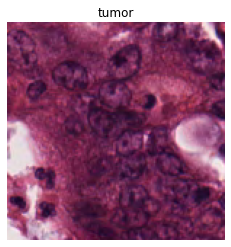

In [ ]:
# showing one image by using the arrays
num = 8

plt.imshow(X[num])
plt.axis('off')
plt.title(class_names[y[num]])
plt.show()

#### Splitting data into test and train

90% of dataset will be used for training, and the rest 10% will be used for testing.

In [ ]:
# split the whole dataset into train and test. 90% train and 10% test.

total_size = X.shape[0] # 5000 samples

train_size = int(0.9 * total_size) # 90% for train dataset. (= 4,500)
test_size = int(0.1 * total_size) # 10% for test dataset. (= 500)

In [ ]:
# split dataset to train/test with 90% train (4,500) and 10% test (500) 

train_images = X[:train_size] # pick first 4500 samples
train_labels = y[:train_size]

test_images = X[-test_size:] # pick last 500 samples
test_labels = y[-test_size:]

print('train ds and labels sizes:' , train_images.shape, train_labels.shape,'\ntest ds and labels sizes:', test_images.shape, test_labels.shape)

train ds and labels sizes: (4500, 150, 150, 3) (4500,) 
test ds and labels sizes: (500, 150, 150, 3) (500,)


#### Converting labels into one-hot tensors

to be able to get probabilities of each class from the models prediction in the future

In [ ]:
# to get probabilities for each class we will need our labels in one-hot tensor

train_labels_onehot = tf.one_hot(train_labels, depth=8, axis=-1)
test_labels_onehot = tf.one_hot(test_labels, depth=8, axis=-1)

#### Checking that train and test dataset both have all the 8 classes

making sure that each dataset has all classes, by using histogram for each dataset, before we begin to train the model 

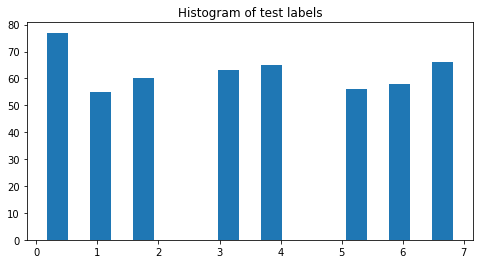

In [ ]:
# check that test/train datasets contain cases from all 8 classes

# test dataset hist
plt.figure(figsize=(8,4))
plt.hist(test_labels, rwidth=0.5)
plt.title('Histogram of test labels')
plt.show()

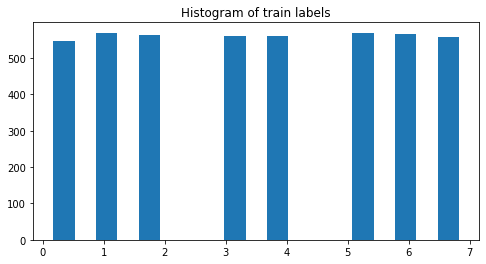

In [ ]:
# train dataset hist
plt.figure(figsize=(8,4))
plt.hist(train_labels, rwidth=0.5)
plt.title('Histogram of train labels')
plt.show()

#### Normalizing images in both datasets

In [ ]:
# normalize range to 0.0-1.0
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

---

### Building Models


#### Building the first model ( very simple custom model )

the first model will be a very simple model, just to see the difference between different models performance.

this simple model wont get any good results, its input is connected straight to 8 dense output.  

In [ ]:
# VERY SIMPLE MODEL

model_simple = Sequential()
model_simple.add(Flatten(input_shape=(150, 150, 3)))
model_simple.add(Dense(8,activation='softmax'))
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 540008    
Total params: 540,008
Trainable params: 540,008
Non-trainable params: 0
_________________________________________________________________


#### Compiling simple model with RMSPROP optimizer and categorical crossentropy loss function

Epoch 1/10
141/141 [==============================] - 3s 11ms/step - loss: 47.3989 - accuracy: 0.1803 - val_loss: 25.9159 - val_accuracy: 0.2700
Epoch 2/10
141/141 [==============================] - 1s 7ms/step - loss: 27.4265 - accuracy: 0.2663 - val_loss: 15.7656 - val_accuracy: 0.2500
Epoch 3/10
141/141 [==============================] - 1s 7ms/step - loss: 25.5812 - accuracy: 0.2908 - val_loss: 25.0034 - val_accuracy: 0.2540
Epoch 4/10
141/141 [==============================] - 1s 7ms/step - loss: 23.7088 - accuracy: 0.3125 - val_loss: 20.4289 - val_accuracy: 0.3520
Epoch 5/10
141/141 [==============================] - 1s 9ms/step - loss: 23.4411 - accuracy: 0.3356 - val_loss: 26.4317 - val_accuracy: 0.3100
Epoch 6/10
141/141 [==============================] - 1s 7ms/step - loss: 21.8874 - accuracy: 0.3486 - val_loss: 23.9080 - val_accuracy: 0.3640
Epoch 7/10
141/141 [==============================] - 1s 7ms/step - loss: 21.0532 - accuracy: 0.3622 - val_loss: 20.4354 - val_accuracy

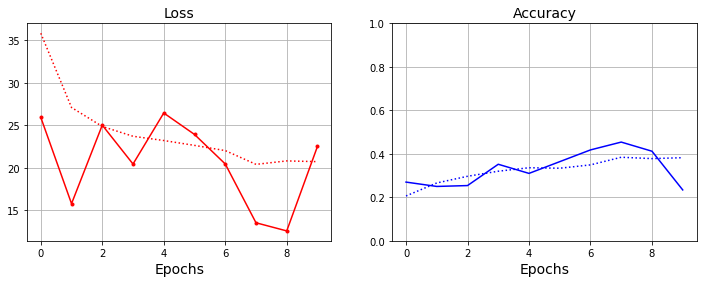

In [ ]:
# compile simple model with rmsprop opt

model_simple.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_simple = model_simple.fit(train_images, train_labels_onehot, epochs=10, batch_size=32, verbose=1,
                    validation_data=(test_images, test_labels_onehot))

print('\n')
print('train accuracy = ',history_simple.history['accuracy'][-1])
print('test accuracy = ',history_simple.history['val_accuracy'][-1])
print('\n')

plot_results(history_simple)

#### The simple model has a very low accuracy and very high loss both in train and in validation.

this model results arent good, lets look at another model.

---

### VGG16 like model

#### Transfer learning

We will use the VGG16 model, but we need to change its top layers to be able to feed images of different size to its network. we need to change the output of the convolutional stack accordingly to our data. In this way, we can apply the VGG16 architecture to images of our size.

paste our own densely connected classifier on top of it: 256 dense layer -> dropout 0.5 -> 8 dense softmax output

freezing the first layer of the network to prevent the weights in this layer from being updated during training.

In [ ]:
# VGG MODEL WITH NEW TOP

model = Sequential()
vgg16 = tf.keras.applications.VGG16(input_shape=(150,150,3), include_top=False) # VGG16 no top
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu')) # adding 256 dense layer
model.add(Dropout(0.5)) # adding dropout
model.add(Dense(8, activation='softmax')) # softmax output

model.layers[0].trainable = False # freezing first layer

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 2,099,464
Non-trainable params: 14,714,688
_________________________________________________________________





Compiling the 'VGG16 like' model with RMSPROP optimizer and categorical crossentropy loss function

In [ ]:
# VGG LIKE MODEL WITH RMSPROP OPT

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels_onehot, epochs=10, batch_size=32, verbose=1,
                    validation_data=(test_images, test_labels_onehot))




train accuracy =  0.9068889021873474
test accuracy =  0.8740000128746033




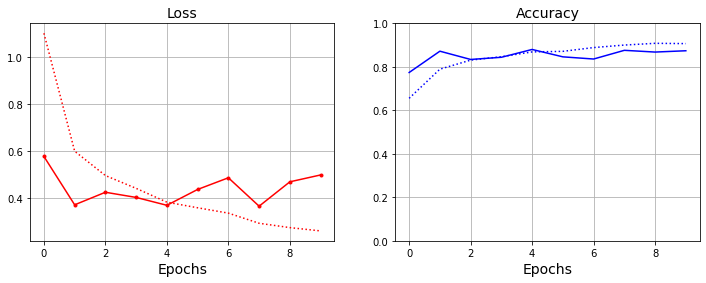

In [ ]:
print('train accuracy = ',history.history['accuracy'][-1])
print('test accuracy = ',history.history['val_accuracy'][-1])
print('\n')

plot_results(history)

#### This model obviously has way better results than the previous one

but after small amount of epochs the test loss starts to increase and there is a difference between the train loss and the test loss, the model performs better on the training data than on the unknown validation data. (overfitting)

---

### Same model with Data Augmentation

adding modified copies of already existing images, to try reducing overfitting.

added rotation, zoom, width/height shift, and horizontal flip, to generate new modified images.

In [ ]:
# DATA AUGMENTATION 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# adding rotation, zoom, shift andd flip
dataGen = ImageDataGenerator(rotation_range=5, zoom_range=0.1, width_shift_range=2,height_shift_range=2, horizontal_flip=True)

train_generator = dataGen.flow(train_images, train_labels_onehot, batch_size=32) # train

validationGen = ImageDataGenerator()
validation_generator = validationGen.flow(test_images, test_labels_onehot, batch_size=32) # test

#### Compiling the same 'VGG16 like' model with data augmentation

again, RMSPROP optimizer and categorical crossentropy loss function.

In [ ]:
# VGG LIKE MODEL WITH DATA AUGMENTATION AND RMSPROP OPTIMIZER 

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_rmsprop_augmentation = model.fit(train_generator, epochs=10, batch_size=32, verbose=1, steps_per_epoch = train_size//32,
                    validation_data=(validation_generator))



train accuracy =  0.8903312683105469
test accuracy =  0.8759999871253967




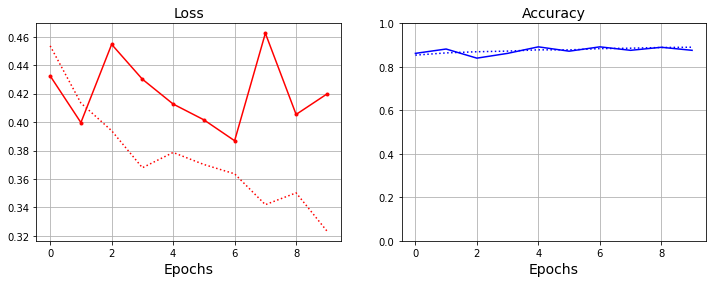

In [ ]:
print('train accuracy = ',history_rmsprop_augmentation.history['accuracy'][-1])
print('test accuracy = ',history_rmsprop_augmentation.history['val_accuracy'][-1])
print('\n')

plot_results(history_rmsprop_augmentation)

#### This time the loss is lower, altough it still has a little overfitting

the accuracy almost didnt change but the loss is lower this time. still theres a difference between the train loss and the validation loss, which may suggest overfitting.

---

### Model Fine Tuning

this time, we unfreeze the first layer of our 'VGG16 like' network, to adapt its features to work with our images, and change optimizer to SGD with lower learning rate, to prevent more overfitting.

In [ ]:
# FINE TUNE

# unfreeze model layers and change learning rate to make better results

model.layers[0].trainable = True

# compile the model
my_opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9) # smaller learning rate
model.compile(optimizer=my_opt, # SGD opt
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model
h2 = model.fit(train_generator, epochs=10, verbose=1,
               steps_per_epoch=train_size//32,
               validation_data=validation_generator)





train accuracy =  0.9456132650375366
test accuracy =  0.9240000247955322




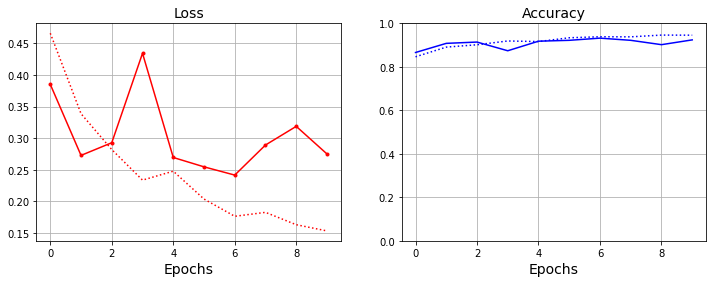

In [ ]:
print('\n')
print('train accuracy = ',h2.history['accuracy'][-1])
print('test accuracy = ',h2.history['val_accuracy'][-1])
print('\n')

plot_results(h2)

#### This time the loss is even lower, and the accuracy is higher, for both train and validation.

even though theres still difference between val loss and train loss (val loss > train loss), 
we get a little better results than the previous run. 

Overall the models accuracy is pretty high in a small number of epochs. so we can use this model for predictions.

---

#### Plotting history of model with data augmentation & fine tuning together in same graph 

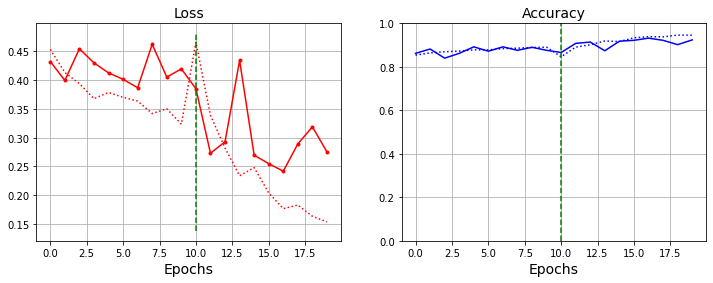

In [ ]:
loss = history_rmsprop_augmentation.history['loss'] + h2.history['loss']
accuracy = history_rmsprop_augmentation.history['accuracy'] + h2.history['accuracy']
val_loss = history_rmsprop_augmentation.history['val_loss'] + h2.history['val_loss']
val_accuracy = history_rmsprop_augmentation.history['val_accuracy'] + h2.history['val_accuracy']


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([10,10], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([10,10], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

### Overall models accuracy results: 

| | train accuracy  | test accuracy    |
|---:|:-------------|:-----------|
| Simple Model | 0.38222  |  0.23399       |
| VGG16 like | 0.90688  | 0.87400    |
| VGG16+Data augmentation | 0.89033 | 0.87599 |
| VGG16+Fine Tuning | 0.94561 | 0.92400 |

---
### Predicting


#### Using 'VGG16 like' model to predict

now we can use our last model to predict classes of images. lets pick a random image and see what the model predicts

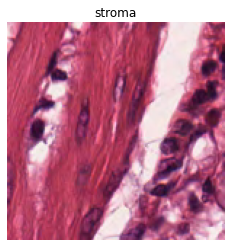

In [ ]:
# IMAGE WITH ITS TRUE LABEL

num = 100

test_img = X[num]
test_img = test_img.astype('float32') / 255.0 # normalize same way we normalized previous samples

plt.imshow(test_img) # plot
plt.title(class_names[y[num]]) # original label
plt.axis('off')
plt.show()

#### Image true label is stroma, and the predicted class of our model is stroma as well. 

In [ ]:
test_img = test_img.reshape(-1, 150,150,3)
pred = np.argmax(model.predict(test_img))

print('predicted class: ',class_names[pred] )

predicted class:  stroma


---

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_images)
matrix = confusion_matrix(test_labels, y_pred.argmax(axis=1)) # confusion matrix
print(matrix)

[[75  0  1  1  0  0  0  0]
 [ 1 46  8  0  0  0  0  0]
 [ 2  2 49  6  1  0  0  0]
 [ 0  0  2 61  0  0  0  0]
 [ 0  7  2  0 54  2  0  0]
 [ 0  0  0  0  0 56  0  0]
 [ 0  0  0  0  1  0 56  1]
 [ 0  0  0  0  0  0  1 65]]



#### Confusion matrix with colors

![confusion_matrix](images/cm.png)

--- 

### Using t-SNE to reduce dimensions to 2D

by using t-SNE we can achieve dimension reduction to visualize our data and see how good each class is separated.

this can be done by taking one-before-last layer of our model with its 256 dimensions and applying t-SNE to reduce the dimensions amount to 2, then plot results on a scatter plot. 

In [ ]:
# we will use the models one before last layer with 256 dimensions
features_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output) # one before last layer
features = features_extractor.predict(test_images) 

features.shape # 500 samples of 256D

(500, 256)

In [ ]:
from sklearn.manifold import TSNE

features_2D = TSNE(n_components=2).fit_transform(features)
features_2D.shape # 500 samples of 2D

(500, 2)

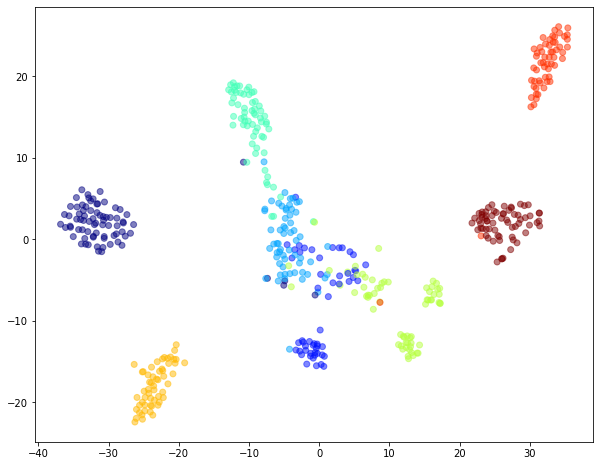

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(features_2D[:,0], features_2D[:,1], c=test_labels, cmap='jet', alpha=0.5) # scatter results
plt.show()

 We can see that most of the classes are seperated very nicely while few classes are not seperated so good. 

---

### Load 'colorectal_histology_large' dataset

The dataset contains 10 5000x5000 images of human colorectal cancer

In [ ]:
# load the colorectal histology dataset with its info

ds_large, ds_large_info = tfds.load('colorectal_histology_large', split='test', shuffle_files=True, with_info=True, download=True)
assert isinstance(ds_large, tf.data.Dataset)
ds_large_info

tfds.core.DatasetInfo(
    name='colorectal_histology_large',
    version=2.0.0,
    description='10 large 5000 x 5000 textured colorectal cancer histology images',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(5000, 5000, 3), dtype=tf.uint8),
    }),
    total_num_examples=10,
    splits={
        'test': 10,
    },
    supervised_keys=None,
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      year={2016},
      publisher={Nature Publishing Group}
    }""",
    redistribution_info=,
)

#### Storing large images in numpy arrays

In [ ]:
large_images = [] # list for images from second dataset (5000x5000 size)

for example in tfds.as_numpy(ds_large): # for each image
  image = example['image']
  large_images.append(image) # add image to list

large_images = np.array(large_images) # convert to numpy array

#### Lets look at one of the images in  'colorectal_histology_large' dataset

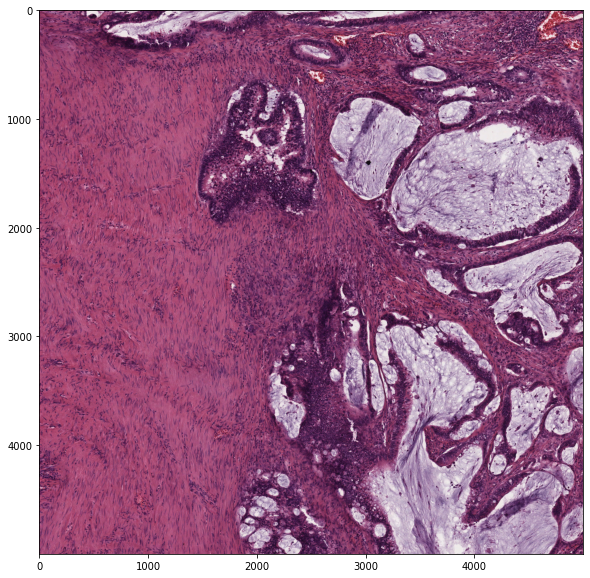

In [ ]:
# picking a large picture

plt.figure(figsize=(10,10))
plt.imshow(large_images[0])

#### We can see that the tissue texture in the image contains several classes.

by using our model, lets try to predict regions of texture in the image and color the image by the classes of tissue types.

'draw_on_img()' gets a 5000x5000 image and returns 2 colored images.

In [ ]:
canv, caner_heatmap = draw_on_img(large_images[0]) # canv = multi-class coloring, cancer_heatmap = tumor probability heatmap

#### present the classification result of the model with multi-class visualization

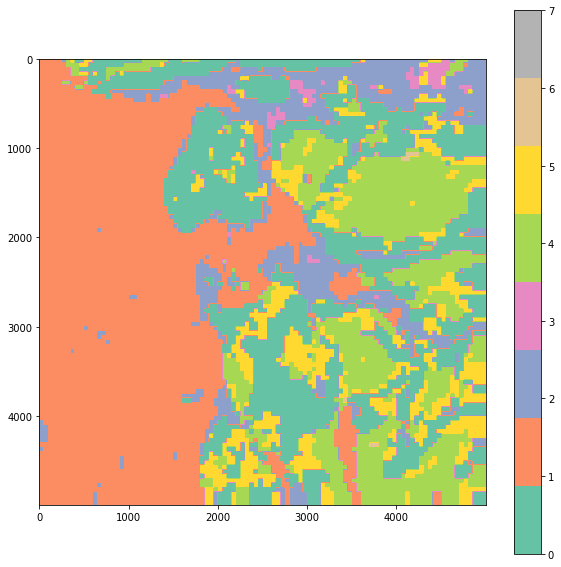

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(canv, cmap='Set2',vmin=0, vmax=7)
plt.colorbar()
plt.show()

#### present the classification result of the model with tumor probability (1=high prob, 0=low prob)

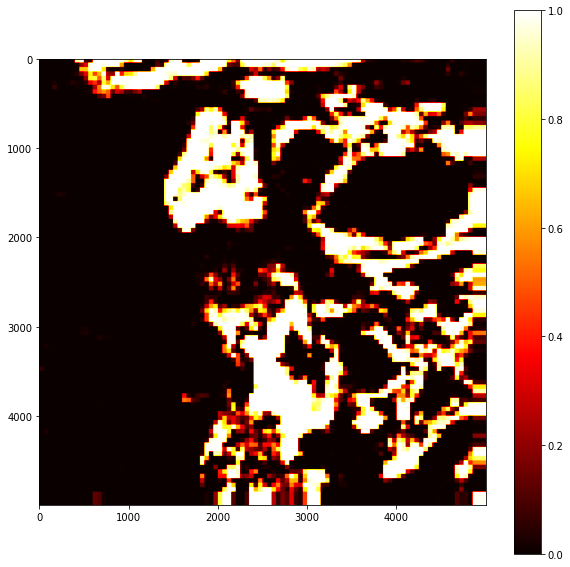

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(caner_heatmap, cmap='hot')
plt.colorbar()
plt.show()

---

#### Applying 'draw_on_img()' on the rest of the large images

create lists to store the images, add the image we already predicted. 

In [ ]:
canv_output = [] # list for all classes output images 
cancer_output = [] # list for cancer output images

canv_output.append(canv) # adding the images we already calculated
cancer_output.append(caner_heatmap)

In [ ]:
for i in range(1,10): # loop through all images (except the first)
  
  canv, cancer_heatmap = draw_on_img(large_images[i]) # prediction

  canv_output.append(canv) # adding predictions to lists
  cancer_output.append(cancer_heatmap)

#### Now that we have all the colored images of the predictions of our model we can plot all of them in the same plot

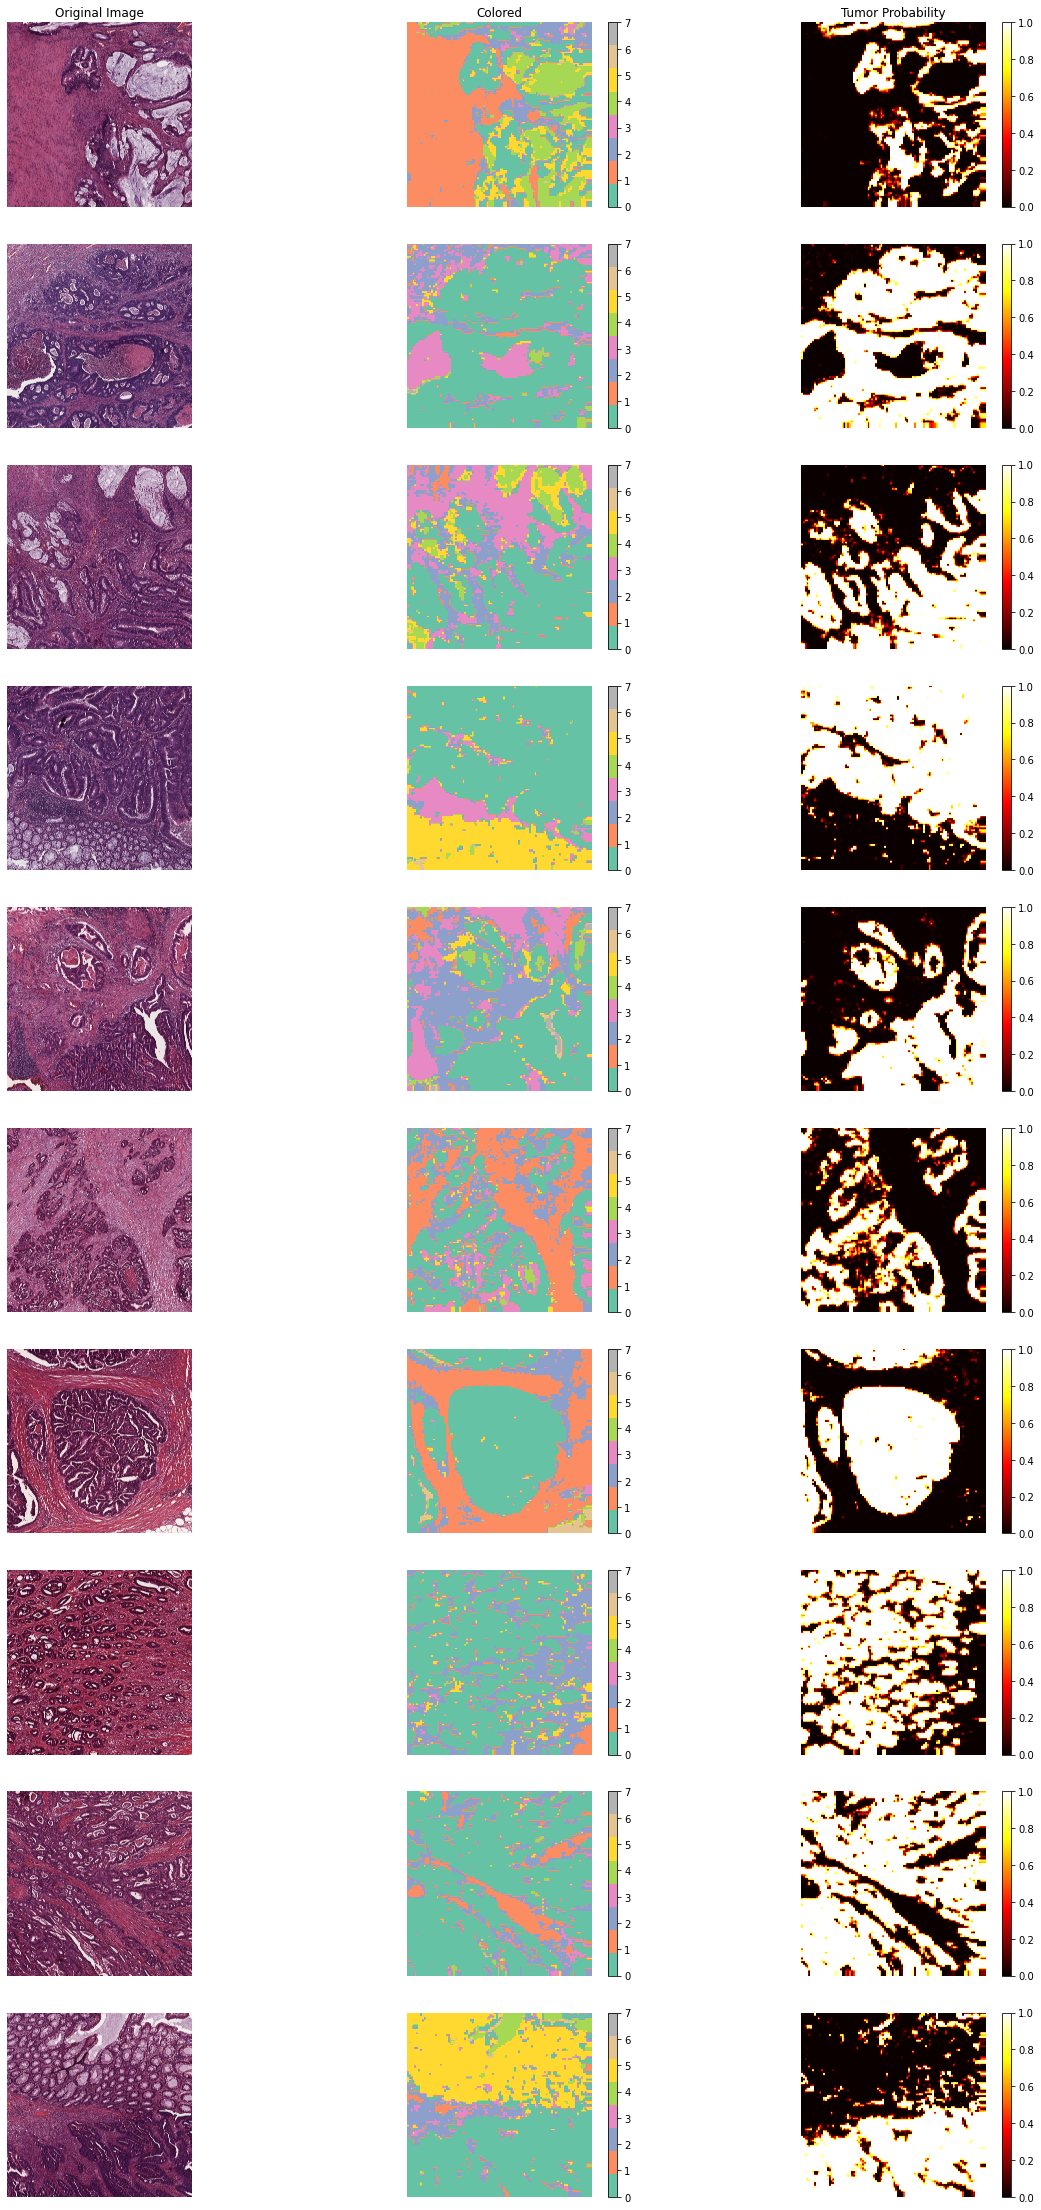

In [ ]:
k = 1 # number in subplot

plt.figure(figsize=(20,40))
for i in range(0,10):
    plt.subplot(10,3,k)
    plt.imshow(large_images[i])
    plt.axis('off')
    if i == 0: # only first image gets a title
        plt.title("Original Image")
    k += 1

    plt.subplot(10,3,k)
    plt.imshow(canv_output[i], cmap='Set2', vmin=0, vmax=7)
    plt.colorbar()
    plt.axis('off')
    if i == 0:
        plt.title("Colored")
    k += 1

    plt.subplot(10,3,k)
    plt.imshow(cancer_output[i], cmap='hot')
    plt.colorbar()
    plt.axis('off')
    if i == 0:
        plt.title('Tumor Probability')
    k += 1

plt.show()

colors (0,1,2,3,4,5,6,7) correspond to 'class_names' respectively

![colorbar_names](images/COLORBARS.png)


---

### Overall

seems like the model can segment tissue types from specified regions of interest, and present results in multi-class visualization and in a specific class probability heatmap (tumor probability in the example above).